# Example usage of the Hybrid Model

In [1]:
# imports
import jax
import jax.numpy as jnp

import jax_cfd.base.equations as eqtns
import jax_cfd.base as cfd
import jax_cfd.base.grids as grids

import jax_cfd.base.advection as advection
import jax_cfd.base.diffusion as diffusion
from jax_cfd.base import finite_differences as fd

import numpy as np #?

import xarray
import seaborn
import pickle

import haiku as hk

import matplotlib.pyplot as plt

import jax_cfd.ml.newSaveObject as saving
import jax_cfd.ml.diego_towers as mytowers

In [68]:
# this allows me to reload a module without having to interrupt the kernel
import importlib
importlib.reload(eqtns)
# importlib.reload(mytowers)

<module 'jax_cfd.base.equations' from '/rds/general/user/dd519/home/FYP/forked_jax/jax-cfd/jax_cfd/base/equations.py'>

In [69]:
## forcings

## Here are different types of forcing functions/conditions

# Linear force due to uniform pressure gradient
def pressure_gradient_forcing(pressure_gradient: float):
  
  def forcing(v):
    force_vector = (pressure_gradient, 0)
    return tuple(cfd.grids.GridArray(f * jnp.ones_like(u.data), u.offset, u.grid)
                 for f, u in zip(force_vector, v))
  
  return forcing

# Turbulent forcing (kolmogorov forcing)
def turbulentForcing(grid):
    return cfd.forcings.simple_turbulence_forcing(grid, constant_magnitude = 0.5, linear_coefficient = -0.8) # params specified in jax-cfd for 2D turbulence

In [70]:
# intialising problem

#grid
#bcs
#initial velocities
#forcing

factor = 1
size = (int(256/factor),int(64/factor))
domain = ((0, 4), (0, 0.5))

# size = (int(64/factor),int(256/factor))
# domain = ((0, 2), (0, 8))


density = 1. ### original 1.
viscosity = 1e-4 # kinematic viscosity ### original 1e-3

pressure_gradient = 2e-3  # uniform dP/dx ### original 2e-3


grid = cfd.grids.Grid(size, domain = domain)


velocity_bc = (cfd.boundaries.channel_flow_boundary_conditions(ndim=2),
               cfd.boundaries.channel_flow_boundary_conditions(ndim=2))

pressure_solve = cfd.pressure.solve_fast_diag_channel_flow ### solve_fast_diag_channel_flow OR solve_cg

vx_fn = lambda x, y: jnp.zeros_like(x) 
vy_fn = lambda x, y: jnp.zeros_like(x)

max_velocity = 1.
cfl_safety_factor = 0.5

# time steps per output
# inner_steps = 1  ## defined below

# number of outputs
# outer_steps = 1000   ## defined below to allow the toTime method to work

forcing = lambda pressure_gradient, grid :  cfd.forcings.sum_forcings(
        pressure_gradient_forcing(pressure_gradient),
        #turbulentForcing(grid),
        cfd.forcings.taylor_green_forcing(grid, scale = 0.05)
        #cfd.forcings.kolmogorov_forcing(grid)
        #cfd.forcings.linear_forcing(grid,1.01)
        #cfd.forcings.filtered_forcing(grid = grid, spectral_density = 1)
        #cfd.forcings.filtered_linear_forcing(grid=grid, upper_wavenumber = 2, coefficient = 1, lower_wavenumber = 1)
)

#######################
# # Evaluate forcing and grid
# for i in range(len(simSpecs)):
#     simSpecs[i]['grid'] = grid = cfd.grids.Grid(simSpecs[i]["size"], 
#                                                               domain=simSpecs[i]["domain"])
#     simSpecs[i]['forcing'] = simSpecs[i]['forcing'](pressure_gradient = simSpecs[i]['pressure_gradient'], 
#                                          grid = simSpecs[i]['grid']
#       )
#######################


forcing = forcing(pressure_gradient = pressure_gradient, 
                  grid = grid)

In [71]:
# finish setting up simulation
v0 = cfd.initial_conditions.initial_velocity_field(
       velocity_fns = (vx_fn, vy_fn),
       grid = grid,
       velocity_bc = velocity_bc,
       pressure_solve = pressure_solve,
       iterations=5)




## divergence check
div = cfd.finite_differences.divergence(v0)
np.testing.assert_allclose(div.data, 0)

# calculate stable timestep (do we need to save this?)
dt = cfd.equations.stable_time_step(max_velocity, 
                                    cfl_safety_factor, 
                                    viscosity, 
                                    grid)

dt

0.00390625

In [72]:
# time steps per output
inner_steps = 1000

# Option ONE
outer_steps = 5

# Option TWO
toTime = True
if toTime:
    target_sim_time = 50 #in time
#     outer_steps = target_sim_time//(inner_steps*dt)
    inner_steps = target_sim_time//(outer_steps*dt)
    
outer_steps

5

In [73]:
inner_steps

2560.0

In [74]:
print("Total simulation time: {:.2f}s".format(inner_steps*outer_steps*dt))

Total simulation time: 50.00s


In [75]:
## define convection function
def convect(v):
  return tuple(
      cfd.advection.advect_van_leer(u, v, dt) for u in v)

## define diffusion function

def diffuse(c, nu):
  """Returns the rate of change in a concentration `c` due to diffusion."""
  return nu * fd.laplacian(c)


In [76]:
def ConvNet(x):
    cnn = mytowers.CNN(CNN_specs)
    return cnn(x)

In [77]:
rng_key = jax.random.PRNGKey(12)

In [92]:
save_path = "./models/final_models/superresolution_BICUBIC_direct_1080.pickle"

with open(save_path,'rb',) as pickle_file:
    loaded = pickle.load(pickle_file)
    CNN_specs = loaded.CNN_specs
    loaded.forward_pass = hk.without_apply_rng(hk.transform(ConvNet))

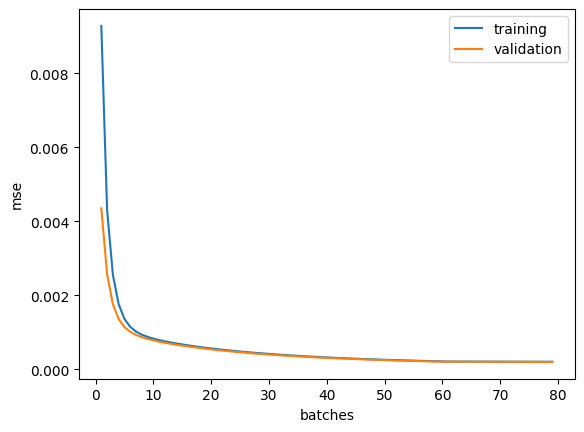

In [94]:

batches = np.arange(len(loaded.losses))
val_step = len(loaded.losses)//len(loaded.val_losses)

batches_val = batches[::val_step]+val_step
plt.plot(batches+1,loaded.losses, label="training")
plt.plot(batches_val,loaded.val_losses,label="validation")
plt.ylabel("mse")
plt.xlabel("batches")
# plt.yscale("log")
plt.legend()

In [80]:
##import models to correct diffusion and convection
# Load corrector/inference network

#laplacian/diffusion
save_path = "./models/final_models/diffusion_1080_direct.pickle"
# save_path = "./models/final_models/diffusion_dropout.pickle"

with open(save_path,'rb',) as pickle_file:
    mylaplacian = pickle.load(pickle_file)
    CNN_specs = mylaplacian.CNN_specs
    mylaplacian.forward_pass = hk.transform(ConvNet)
    
def diffuse(c,nu):
    return nu * mylaplacian.forward_pass.apply(mylaplacian.params,rng_key,c)

# convection
save_path = "./models/final_models/advection_1.pickle"

with open(save_path,'rb',) as pickle_file:
    myconvect = pickle.load(pickle_file)
    CNN_specs = myconvect.CNN_specs
    myconvect.forward_pass = hk.without_apply_rng(hk.transform(ConvNet))
    
def convect(v):
    print(np.shape(v))
    return myconvect.forward_pass.apply(myconvect.params,v)

## Defining and choosing from a number of different numerical step functions

In [81]:
# define function to advance one timestep

# Semi-implicit Navier Stokes
NS_step_functions = {    
    "navier_stokes_explicit_terms" : cfd.equations.navier_stokes_explicit_terms(
                                                density=density,
                                                viscosity=viscosity,
                                                dt=dt,
                                                grid=grid,
                                                convect=convect,
                                                forcing= forcing
    ),
    
    "semi_implicit_navier_stokes" : cfd.equations.semi_implicit_navier_stokes(
                                                density=density,
                                                viscosity=viscosity,
                                                dt=dt,
                                                grid=grid,
                                                convect=convect,
                                                pressure_solve = pressure_solve,
#                                                 diffuse = diffuse,
                                                forcing= forcing
    ),
    "corrected_semi_implicit_navier_stokes" : cfd.equations.corrected_semi_implicit_navier_stokes(
                                                density=density,
                                                viscosity=viscosity,
                                                dt=dt,
                                                grid=grid,
                                                convect=convect,
                                                pressure_solve = pressure_solve,
                                                diffuse = diffuse,
                                                forcing= forcing
    ),
    
    "implicit_diffusion_navier_stokes" : cfd.equations.implicit_diffusion_navier_stokes(
                                                density=density,
                                                viscosity=viscosity,
                                                dt=dt,
                                                grid=grid,
                                                convect=convect,
                                                pressure_solve = pressure_solve,
                                                forcing= forcing
    )
        
}


# NS_step = NS_step_functions["semi_implicit_navier_stokes"]
NS_step = NS_step_functions["corrected_semi_implicit_navier_stokes"]

## Defining the ML section of the solver


In [82]:
jax.config.update("jax_disable_jit", False) #True for debugging, False for fast execution
single_step = cfd.funcutils.repeated(NS_step,steps=inner_steps)

In [83]:
# jax.jit function enables execution on CPU/GPU/TPU
rollout_fn = cfd.funcutils.trajectory(
    single_step, outer_steps, start_with_input=True)

In [84]:
## compute trajectory
%time _, trajectory = jax.device_get(rollout_fn(v0))

CPU times: user 1h 56min 26s, sys: 6h 7min 35s, total: 8h 4min 2s
Wall time: 45min 6s


In [85]:
# load into xarray for visualization and analysis
ds = xarray.Dataset(
    {
        'u': (('time', 'x', 'y'), trajectory[0].data),
        'v': (('time', 'x', 'y'), trajectory[1].data),
    },
    coords={
        'x': grid.axes()[0],
        'y': grid.axes()[1],
        'time': dt * inner_steps * np.arange(1, outer_steps + 1)
    }
)

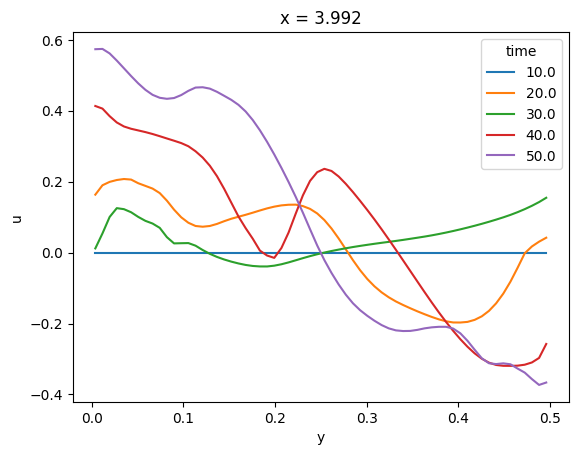

In [86]:
def vx_at_x_upper_boundary(ds):
  return ds.u.isel(x=-1)  # slice operator

p = ds.pipe(vx_at_x_upper_boundary).plot(hue='time')

<AxesSubplot: >

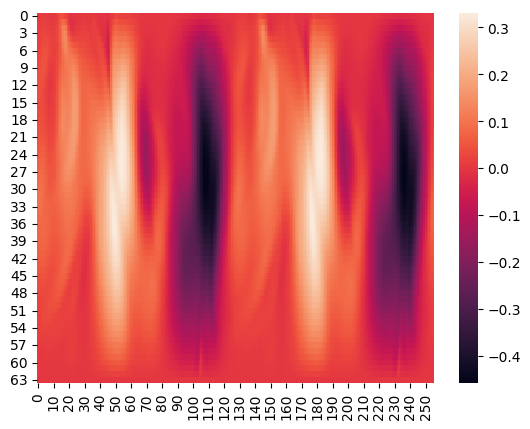

In [87]:
seaborn.heatmap(ds.v.isel(time=-1).T)

<AxesSubplot: >

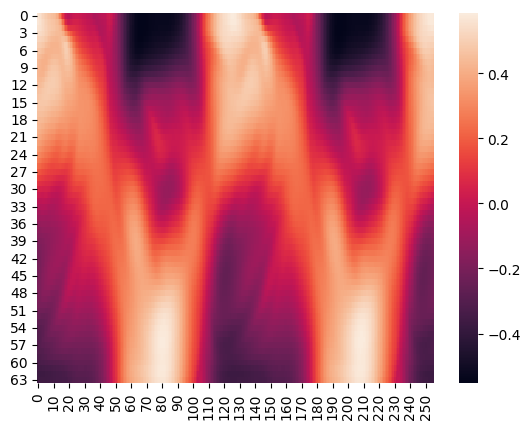

In [88]:
seaborn.heatmap(ds.u.isel(time=-1).T)

In [89]:
ds.time

<xarray.DataArray 'time' (time: 5)>
array([10., 20., 30., 40., 50.])
Coordinates:
  * time     (time) float64 10.0 20.0 30.0 40.0 50.0

In [91]:
save_dataset = ds
save_dataset_path = './sims_50_seconds/' + 'LI_diffuse_256x64' + '.nc'
save_dataset.to_netcdf(path=save_dataset_path)